In [ ]:
import numpy as np

def make_moons_from_scratch(n_samples=500, noise=0.2, random_state=1337, shuffle=True):
    """
    Generate a two-moons dataset (no sklearn).
    Returns X (n_samples,2), y (n_samples,) with labels 0/1.
    """
    rng = np.random.default_rng(random_state)
    n_out = n_samples // 2
    n_in  = n_samples - n_out

    angles_out = rng.random(n_out) * np.pi
    angles_in  = rng.random(n_in)  * np.pi

    outer_x = np.cos(angles_out)
    outer_y = np.sin(angles_out)
    outer = np.column_stack([outer_x, outer_y])

    inner_x = 1.0 - np.cos(angles_in)
    inner_y = 0.5 - np.sin(angles_in)
    inner = np.column_stack([inner_x, inner_y])

    X = np.vstack([outer, inner])
    y = np.hstack([np.zeros(n_out, dtype=int), np.ones(n_in, dtype=int)])

    if noise is not None and noise > 0:
        X += rng.normal(scale=noise, size=X.shape)

    if shuffle:
        idx = rng.permutation(n_samples)
        X = X[idx]
        y = y[idx]

    return X, y

RSEED = 1337

X_train_full, y_train_full = make_moons_from_scratch(n_samples=500, noise=0.2, random_state=RSEED)


X_test_02, y_test_02 = make_moons_from_scratch(n_samples=500, noise=0.2, random_state=RSEED + 1)
X_test_01, y_test_01 = make_moons_from_scratch(n_samples=500, noise=0.1, random_state=RSEED + 2)
X_test_03, y_test_03 = make_moons_from_scratch(n_samples=500, noise=0.3, random_state=RSEED + 3)


print("Shapes:", X_train_full.shape, y_train_full.shape,
      X_test_02.shape, y_test_02.shape, X_test_01.shape, y_test_01.shape, X_test_03.shape, y_test_03.shape)


Shapes: (500, 2) (500,) (500, 2) (500,) (500, 2) (500,) (500, 2) (500,)


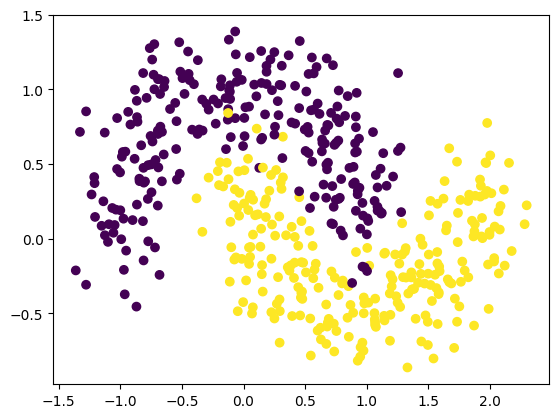

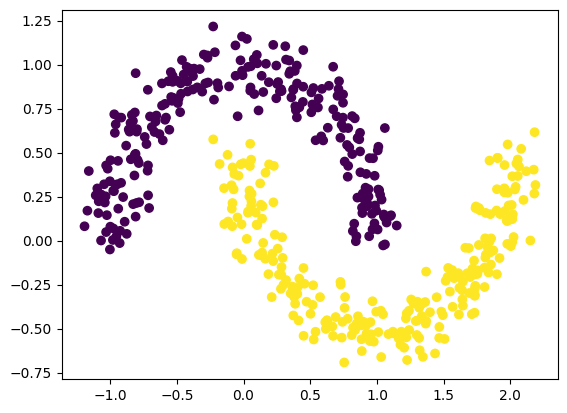

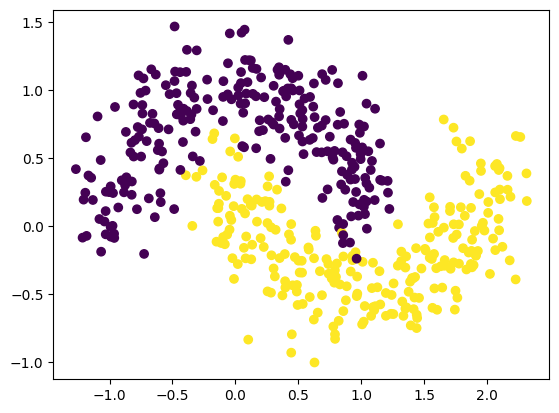

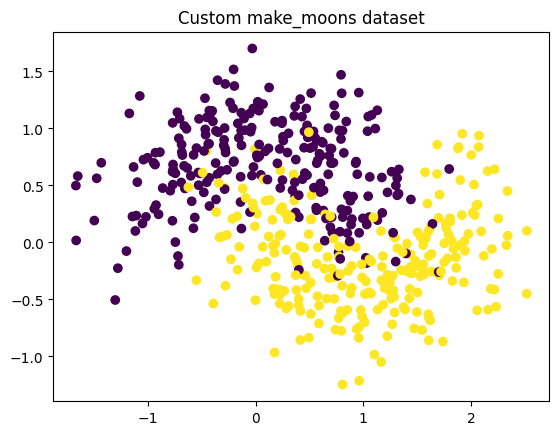

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X_train_full[:, 0], X_train_full[:, 1], c=y_train_full)
plt.show()
plt.scatter(X_test_01[:, 0], X_test_01[:, 1], c=y_test_01)
plt.show()
plt.scatter(X_test_02[:, 0], X_test_02[:, 1], c=y_test_02)
plt.show()
plt.scatter(X_test_03[:, 0], X_test_03[:, 1], c=y_test_03)
plt.title("Custom make_moons dataset")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2, random_state=RSEED, stratify=y_train_full
)

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_val   = (X_val - mean) / std
X_test_01 = (X_test_01 - mean) / std
X_test_02 = (X_test_02 - mean) / std
X_test_03 = (X_test_03 - mean) / std

print("Means (train):", mean)
print("Stds (train):", std)
print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test_02.shape)


Means (train): [0.451023  0.2650595]
Stds (train): [0.88983985 0.52717906]
Train/Val/Test shapes: (400, 2) (100, 2) (500, 2)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:",device)

Using device: cuda


In [ ]:
def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train, y_train)
X_val_t, y_val_t     = to_tensor(X_val, y_val)
X_test1_t, y_test1_t = to_tensor(X_test_01, y_test_01)   
X_test2_t, y_test2_t = to_tensor(X_test_02, y_test_02)   
X_test3_t, y_test3_t = to_tensor(X_test_03, y_test_03)   

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32)

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
def train_mlp_earlystop(model, train_loader, val_loader, lr=0.01, patience=50, max_epochs=1000):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = np.inf
    best_model = None
    epochs_no_improve = 0
    train_losses, val_losses = [], []

    for epoch in range(max_epochs):
        model.train()
        batch_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            batch_train_loss += loss.item()
        train_loss = batch_train_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model)
    model_mlp = model
    return model, train_losses, val_losses

In [10]:
def evaluate_acc(model, X, y):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(device)
        preds = torch.sigmoid(model(X_t))
        acc = ((preds > 0.5).float() == y_t).float().mean().item()
    return acc

In [14]:
model = MLP()
model_mlp, train_losses, val_losses = train_mlp_earlystop(model, train_loader, val_loader)

Early stopping at epoch 141


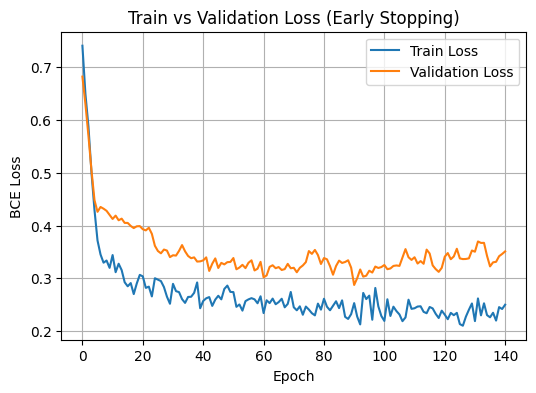

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Train vs Validation Loss (Early Stopping)")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
acc_test1 = evaluate_acc(model, X_test_01, y_test_01)   # noise=0.2
acc_test2 = evaluate_acc(model, X_test_02, y_test_02)   # noise=0.1
acc_test3 = evaluate_acc(model, X_test_03, y_test_03)   # noise=0.3

print(f"Test Accuracy (noise=0.2): {acc_test1*100:.2f}%")
print(f"Test Accuracy (noise=0.1): {acc_test2*100:.2f}%")
print(f"Test Accuracy (noise=0.3): {acc_test3*100:.2f}%")

Test Accuracy (noise=0.2): 92.40%
Test Accuracy (noise=0.1): 93.60%
Test Accuracy (noise=0.3): 88.80%


## Model 2


In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
def compute_sparsity(model):
    sparsity = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            zeros = torch.sum(param == 0).item()
            total = param.numel()
            sparsity[name] = 100.0 * zeros / total
    return sparsity

In [ ]:
def train_mlp_l1(model, train_loader, val_loader, l1_lambda=0.0, lr=0.01, epochs=300):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)

            l1_penalty = 0
            for param in model.parameters():
                l1_penalty += torch.sum(torch.abs(param))
            loss += l1_lambda * l1_penalty

            loss.backward()
            optimizer.step()
    return model


In [17]:
from sklearn.metrics import roc_auc_score

def evaluate_metrics(model, X, y):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(device)
        logits = model(X_t)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(float)
        acc = (preds == y.reshape(-1, 1)).mean()
        auc = roc_auc_score(y, probs)
    return acc, auc

In [ ]:
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_aucs = []
sparsities = []
results = []

best_auc = 0
best_model = None
best_lambda = None

for lam in l1_grid:
    model = MLP()
    best_model_l1 = train_mlp_l1(model, train_loader, val_loader, l1_lambda=lam)

    val_acc, val_auc = evaluate_metrics(model, X_val, y_val)
    val_aucs.append(val_auc)

    layer_sparsity = compute_sparsity(model)
    s_fc1, s_fc2 = layer_sparsity['fc1.weight'], layer_sparsity['fc2.weight']
    avg_sparsity = np.mean(list(layer_sparsity.values()))
    sparsities.append(avg_sparsity)

    acc_test_02, _ = evaluate_metrics(model, X_test_01, y_test_01) 
    acc_test_01, _ = evaluate_metrics(model, X_test_02, y_test_02) 
    acc_test_03, _ = evaluate_metrics(model, X_test_03, y_test_03)  

    results.append({
        'λ': lam,
        'Val_AUROC': val_auc,
        'Sparsity_fc1(%)': s_fc1,
        'Sparsity_fc2(%)': s_fc2,
        'Avg_Sparsity(%)': avg_sparsity,
        'Acc_noise=0.10': acc_test_01,
        'Acc_noise=0.20': acc_test_02,
        'Acc_noise=0.30': acc_test_03
    })

    print(f"λ={lam:.1e} | Val AUROC={val_auc:.4f} | Sparsity fc1={s_fc1:.2f}% fc2={s_fc2:.2f}%")

    if val_auc > best_auc:
        best_auc = val_auc
        best_model = model
        best_lambda = lam

λ=1.0e-06 | Val AUROC=0.9928 | Sparsity fc1=0.00% fc2=0.00%
λ=3.0e-06 | Val AUROC=0.9728 | Sparsity fc1=0.00% fc2=0.00%
λ=1.0e-05 | Val AUROC=0.9908 | Sparsity fc1=0.00% fc2=0.00%
λ=3.0e-05 | Val AUROC=0.9904 | Sparsity fc1=0.00% fc2=0.00%
λ=1.0e-04 | Val AUROC=0.9952 | Sparsity fc1=0.00% fc2=0.00%
λ=3.0e-04 | Val AUROC=0.9896 | Sparsity fc1=0.00% fc2=0.00%


In [19]:
import pandas as pd

df_results = pd.DataFrame(results)
print("\n=== L1 Regularization Results Summary ===")
print(df_results.round(4))

print(f"\nBest λ = {best_lambda:.1e} with Val AUROC = {best_auc:.4f}")


=== L1 Regularization Results Summary ===
        λ  Val_AUROC  Sparsity_fc1(%)  Sparsity_fc2(%)  Avg_Sparsity(%)  \
0  0.0000     0.9928              0.0              0.0              0.0   
1  0.0000     0.9728              0.0              0.0              0.0   
2  0.0000     0.9908              0.0              0.0              0.0   
3  0.0000     0.9904              0.0              0.0              0.0   
4  0.0001     0.9952              0.0              0.0              0.0   
5  0.0003     0.9896              0.0              0.0              0.0   

   Acc_noise=0.10  Acc_noise=0.20  Acc_noise=0.30  
0           0.972           0.990           0.920  
1           0.930           0.918           0.896  
2           0.968           0.986           0.920  
3           0.970           0.988           0.926  
4           0.964           0.980           0.914  
5           0.960           0.974           0.918  

Best λ = 1.0e-04 with Val AUROC = 0.9952


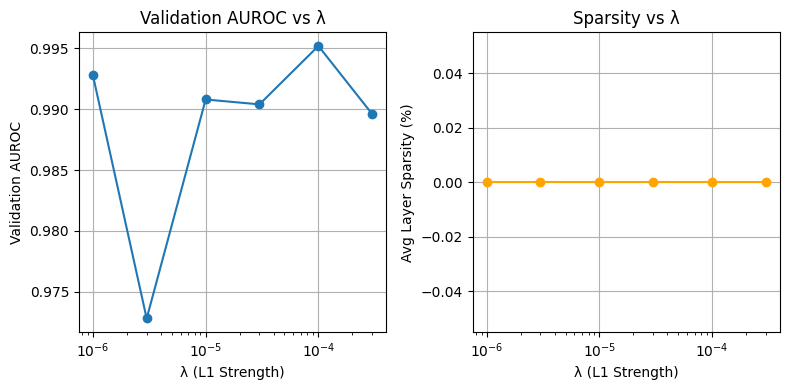

In [20]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(l1_grid, val_aucs, marker='o')
plt.xscale('log')
plt.xlabel("λ (L1 Strength)")
plt.ylabel("Validation AUROC")
plt.title("Validation AUROC vs λ")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(l1_grid, sparsities, marker='o', color='orange')
plt.xscale('log')
plt.xlabel("λ (L1 Strength)")
plt.ylabel("Avg Layer Sparsity (%)")
plt.title("Sparsity vs λ")
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
acc_test1, _ = evaluate_metrics(best_model, X_test_01, y_test_01)
acc_test2, _ = evaluate_metrics(best_model, X_test_02, y_test_02)
acc_test3, _ = evaluate_metrics(best_model, X_test_03, y_test_03)

print(f"\n=== Best L1 Model Test Accuracies ===")
print(f"Noise=0.10: {acc_test2*100:.2f}%")
print(f"Noise=0.20: {acc_test1*100:.2f}%")
print(f"Noise=0.30: {acc_test3*100:.2f}%")


=== Best L1 Model Test Accuracies ===
Noise=0.10: 96.40%
Noise=0.20: 98.00%
Noise=0.30: 91.40%


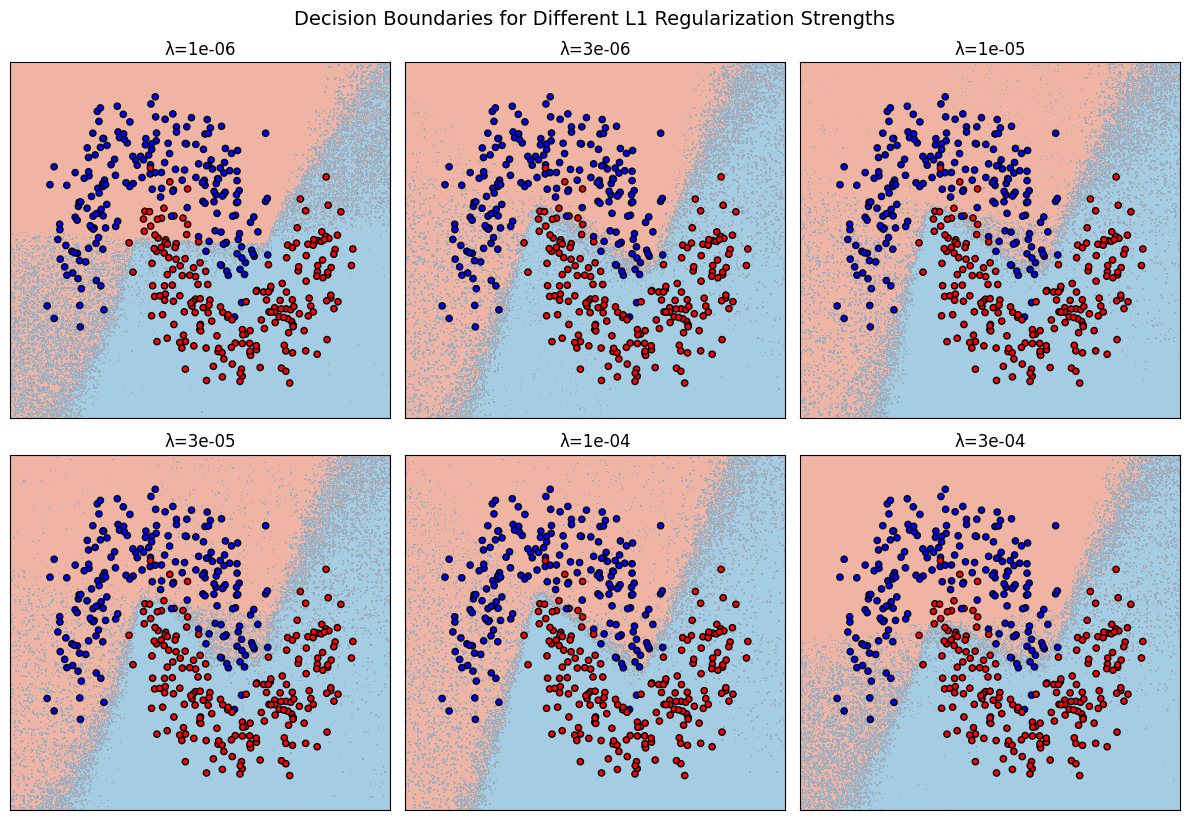

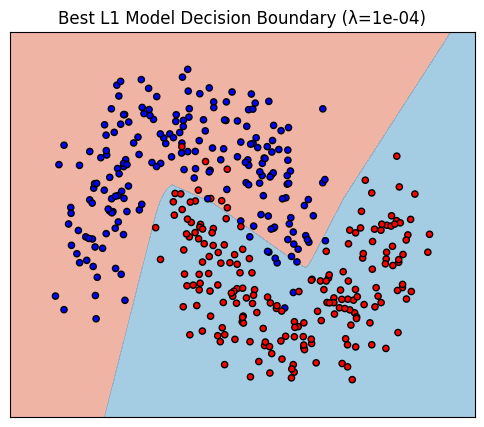

In [ ]:

def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        Z = torch.sigmoid(model(torch.tensor(grid, dtype=torch.float32).to(device))).cpu().numpy()
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="RdBu", alpha=0.6)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolor="k", s=20)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.figure(figsize=(12, 8))
for i, lam in enumerate(l1_grid):
    plt.subplot(2, 3, i + 1)
    model_vis = MLP()
    model_vis = train_mlp_l1(model_vis, train_loader, val_loader, l1_lambda=lam, epochs=200)
    plot_decision_boundary(model_vis, X_train, y_train, plt.gca(), f"λ={lam:.0e}")
plt.tight_layout()
plt.suptitle("Decision Boundaries for Different L1 Regularization Strengths", y=1.02, fontsize=14)
plt.show()


best_acc, best_auc = evaluate_metrics(best_model, X_val, y_val)

plt.figure(figsize=(6, 5))
plot_decision_boundary(best_model, X_train, y_train, plt.gca(),
                       f"Best λ={best_lambda:.0e}\nVal AUROC={best_auc:.3f} | Val Acc={best_acc*100:.2f}%")
plt.title(f"Best L1 Model Decision Boundary (λ={best_lambda:.0e})", fontsize=12)
plt.show()


## model 3

In [23]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
def train_mlp_l2(model, train_loader, val_loader, lr=0.01, weight_decay=0.0, epochs=300):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
    return model

In [25]:
def evaluate_metrics(model, X, y):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        y_t = torch.tensor(y.reshape(-1,1), dtype=torch.float32).to(device)
        logits = model(X_t)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(float)
        acc = (preds == y.reshape(-1,1)).mean()
        auc = roc_auc_score(y, probs)
    return acc, auc

In [26]:
l2_grid = [0.0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
val_aucs = []
best_auc = 0
best_model = None
best_l2 = None

for wd in l2_grid:
    model = MLP()
    best_model_l2 = train_mlp_l2(model, train_loader, val_loader, weight_decay=wd)
    _, val_auc = evaluate_metrics(model, X_val, y_val)
    val_aucs.append(val_auc)
    print(f"L2={wd:.0e} | Val AUROC={val_auc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        best_model = model
        best_l2 = wd

print(f"\nBest L2 (weight_decay) = {best_l2:.1e} | Val AUROC = {best_auc:.4f}")


L2=0e+00 | Val AUROC=0.9892
L2=1e-05 | Val AUROC=0.9900
L2=3e-05 | Val AUROC=0.9964
L2=1e-04 | Val AUROC=0.9912
L2=3e-04 | Val AUROC=0.9908
L2=1e-03 | Val AUROC=0.9904

Best L2 (weight_decay) = 3.0e-05 | Val AUROC = 0.9964


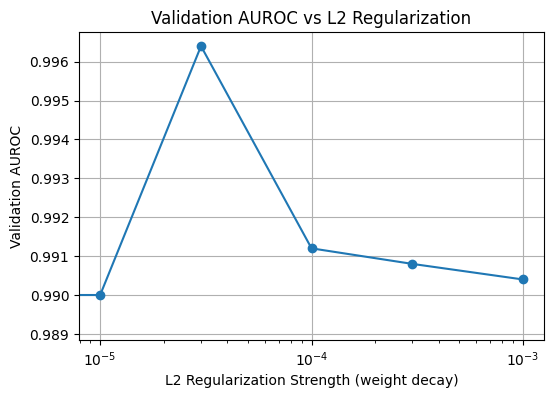

In [27]:
plt.figure(figsize=(6,4))
plt.plot(l2_grid, val_aucs, marker='o')
plt.xscale('log')
plt.xlabel("L2 Regularization Strength (weight decay)")
plt.ylabel("Validation AUROC")
plt.title("Validation AUROC vs L2 Regularization")
plt.grid(True)
plt.show()

In [28]:
acc_test_02, _ = evaluate_metrics(best_model, X_test_01, y_test_01)
acc_test_01, _ = evaluate_metrics(best_model, X_test_02, y_test_02)
acc_test_03, _ = evaluate_metrics(best_model, X_test_03, y_test_03)

print(f"\nTest Accuracy (noise=0.20): {acc_test_02*100:.2f}%")
print(f"Robustness Accuracy (noise=0.10): {acc_test_01*100:.2f}%")
print(f"Robustness Accuracy (noise=0.30): {acc_test_03*100:.2f}%")


Test Accuracy (noise=0.20): 99.60%
Robustness Accuracy (noise=0.10): 97.00%
Robustness Accuracy (noise=0.30): 92.00%


## Model 4


Polynomial Logistic Regression Results:
Noise=0.2: Accuracy=100.00% | AUROC=1.000
Noise=0.1: Accuracy=97.40% | AUROC=0.999
Noise=0.3: Accuracy=90.40% | AUROC=0.967


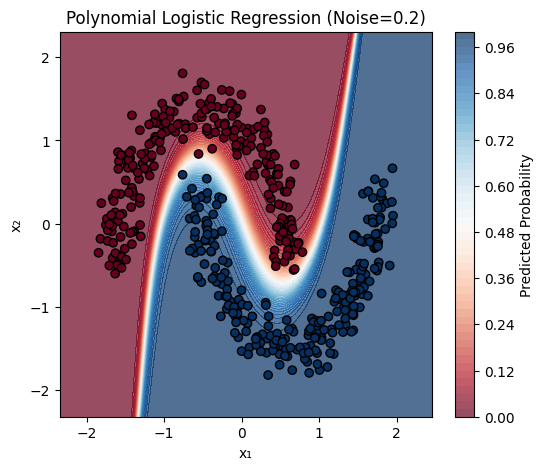

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class LogisticRegressionPoly(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)


def train_logistic_reg(model, train_loader, val_loader, lr=0.01, max_epochs=500, patience=50):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    best_state = None
    epochs_no_improve = 0
    
    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item()
        val_loss /= len(val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break
    
    model.load_state_dict(best_state)
    return model


def evaluate_metrics(model, X, y):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(device)
        logits = model(X_t)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(float)
        acc = (preds == y.reshape(-1, 1)).mean()
        auc = roc_auc_score(y, probs)
    return acc, auc

def plot_decision_boundary(model, poly, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_poly = poly.transform(grid)
    grid_poly_t = torch.tensor(grid_poly, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(grid_poly_t)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.7)
    plt.colorbar(label="Predicted Probability")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdBu", edgecolors="k")
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.show()


poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_val_poly   = poly.transform(X_val)
X_test1_poly = poly.transform(X_test_01)
X_test2_poly = poly.transform(X_test_02)
X_test3_poly = poly.transform(X_test_03)


def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train_poly, y_train)
X_val_t, y_val_t = to_tensor(X_val_poly, y_val)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32)


input_dim = X_train_poly.shape[1]
model = LogisticRegressionPoly(input_dim)
model_poly = train_logistic_reg(model, train_loader, val_loader)


acc_test1, auc_test1 = evaluate_metrics(model, X_test1_poly, y_test_01)
acc_test2, auc_test2 = evaluate_metrics(model, X_test2_poly, y_test_02)
acc_test3, auc_test3 = evaluate_metrics(model, X_test3_poly, y_test_03)

print("\nPolynomial Logistic Regression Results:")
print(f"Noise=0.2: Accuracy={acc_test1*100:.2f}% | AUROC={auc_test1:.3f}")
print(f"Noise=0.1: Accuracy={acc_test2*100:.2f}% | AUROC={auc_test2:.3f}")
print(f"Noise=0.3: Accuracy={acc_test3*100:.2f}% | AUROC={auc_test3:.3f}")


plot_decision_boundary(model, poly, X_test_01, y_test_01, title="Polynomial Logistic Regression (Noise=0.2)")


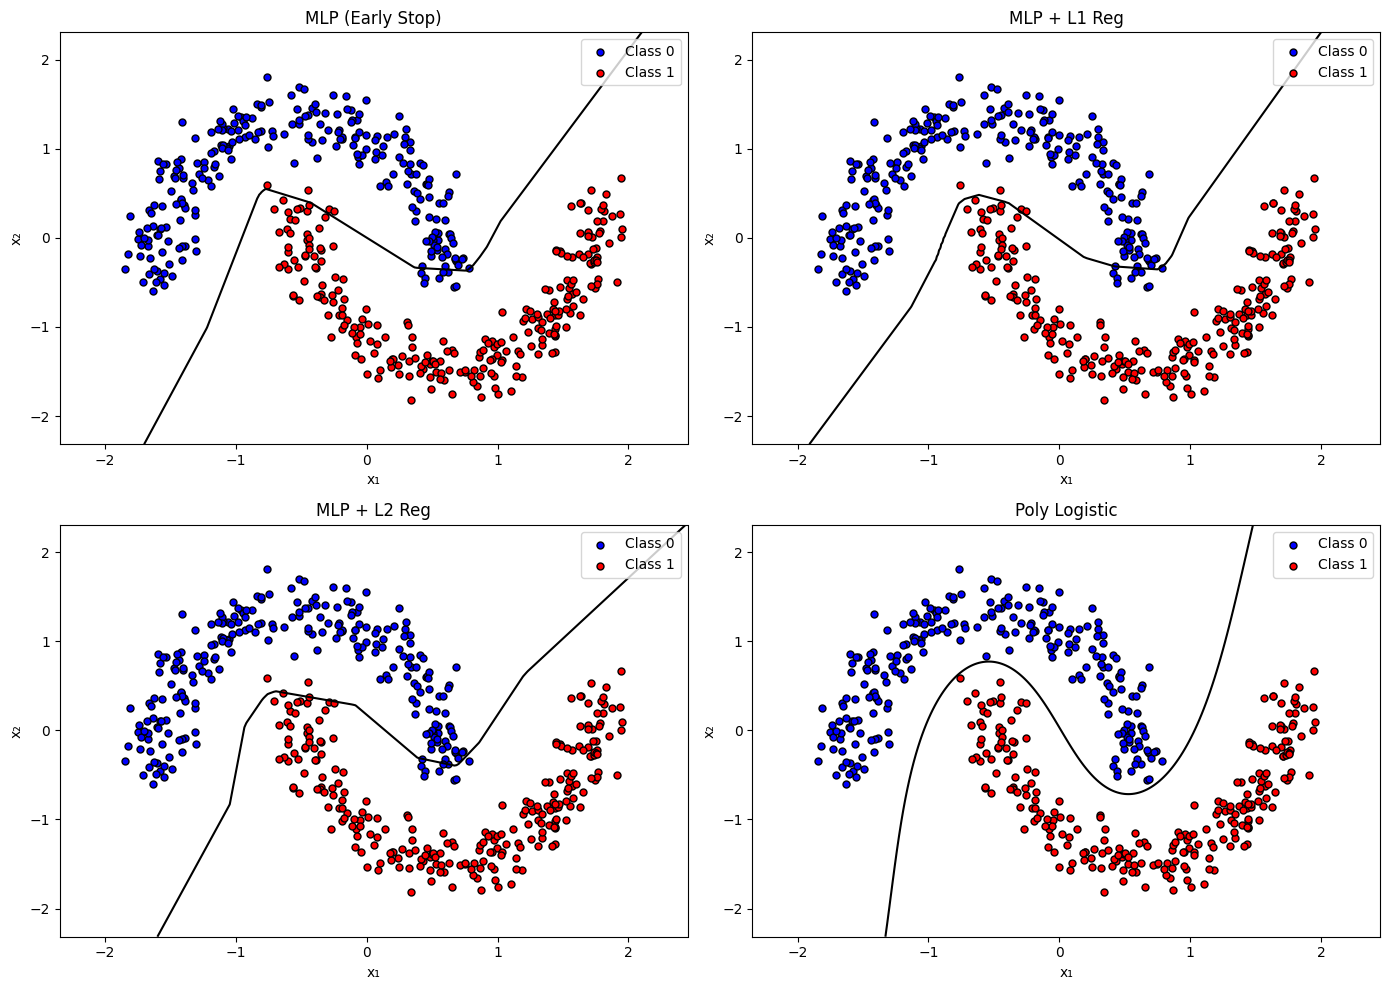

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_decision_boundary_subplot(ax, model, X, y, title, poly=None):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    if poly is not None:
        grid = poly.transform(grid)
    
    grid_t = torch.tensor(grid, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        preds = torch.sigmoid(model(grid_t)).cpu().numpy().reshape(xx.shape)
    
    ax.contour(xx, yy, preds, levels=[0.5], colors='k', linewidths=1.5)
    
    ax.scatter(X[y==0, 0], X[y==0, 1], color='blue', label='Class 0', s=25, edgecolor='k')
    ax.scatter(X[y==1, 0], X[y==1, 1], color='red', label='Class 1', s=25, edgecolor='k')

    ax.set_title(title)
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.legend()


plt.figure(figsize=(14, 10))
models = [
    (model_mlp,       "MLP (Early Stop)", None),
    (best_model_l1,   "MLP + L1 Reg",     None),
    (best_model_l2,   "MLP + L2 Reg",     None),
    (model_poly,      "Poly Logistic",    poly)
]

for i, (m, title, p) in enumerate(models, 1):
    ax = plt.subplot(2, 2, i)
    plot_decision_boundary_subplot(ax, m, X_test_01, y_test_01, title, poly=p)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch


def evaluate_accuracy(model, X, y, poly=None):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    if poly is not None:
        X_t = torch.tensor(poly.transform(X), dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    with torch.no_grad():
        preds = (torch.sigmoid(model(X_t)) > 0.5).float()
    return (preds.cpu() == y_t.cpu()).float().mean().item()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


results = []

models = [
    ("MLP (Early Stop)", model_mlp, None),
    ("MLP + L1 Reg", best_model_l1, None),
    ("MLP + L2 Reg", best_model_l2, None),
    ("Poly Logistic", model_poly, poly)
]

test_sets = [
    ("Test (noise=0.10)", X_test_01, y_test_01),
    ("Test (noise=0.20)", X_test_02, y_test_02),
    ("Test (noise=0.30)", X_test_03, y_test_03)
]

for name, model, p in models:
    param_count = count_parameters(model)
    accs = []
    for _, X, y in test_sets:
        acc = evaluate_accuracy(model, X, y, poly=p)
        accs.append(acc)
    results.append({
        "Model": name,
        "Params": param_count,
        "Acc (0.10 noise)": round(accs[0], 4),
        "Acc (0.20 noise)": round(accs[1], 4),
        "Acc (0.30 noise)": round(accs[2], 4)
    })

df_summary = pd.DataFrame(results)
print("\n=== Model Performance Summary ===")
display(df_summary)



=== Model Performance Summary ===


,Model,Params,Acc (0.10 noise),Acc (0.20 noise),Acc (0.30 noise)
0,MLP (Early Stop),33,0.976,0.962,0.920
1,MLP + L1 Reg,41,0.974,0.960,0.918
2,MLP + L2 Reg,41,0.976,0.964,0.916
3,Poly Logistic,11,1.000,0.974,0.904


## Imbalance class

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression



def make_imbalanced_dataset(X, y, ratio=0.7, seed=1337):
    np.random.seed(seed)
    class0_idx = np.where(y == 0)[0]
    class1_idx = np.where(y == 1)[0]

    n_class0 = int(len(y) * ratio)
    n_class1 = len(y) - n_class0

    chosen0 = np.random.choice(class0_idx, n_class0, replace=True)
    chosen1 = np.random.choice(class1_idx, n_class1, replace=True)
    idx = np.concatenate([chosen0, chosen1])
    np.random.shuffle(idx)

    return X[idx], y[idx]


In [ ]:

X_train_imbal, y_train_imbal = make_imbalanced_dataset(X_train, y_train, ratio=0.7)

print(f"Class distribution after imbalance: "
      f"Class 0 = {(y_train_imbal==0).mean()*100:.1f}%, "
      f"Class 1 = {(y_train_imbal==1).mean()*100:.1f}%")

Class distribution after imbalance: Class 0 = 70.0%, Class 1 = 30.0%


In [ ]:

from sklearn.model_selection import train_test_split
X_train_imbal, X_val_imbal, y_train_imbal, y_val_imbal = train_test_split(
    X_train_imbal, y_train_imbal, test_size=0.2, random_state=1337, stratify=y_train_imbal
)


def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y.reshape(-1,1), dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train_imbal, y_train_imbal)
X_val_t,   y_val_t   = to_tensor(X_val_imbal, y_val_imbal)

train_loader_imbal = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader_imbal   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=32)

In [65]:
def evaluate_metrics(model, X, y, poly=None):
    model.eval()
    if poly is not None:
        X = poly.transform(X)
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    y_t = torch.tensor(y.reshape(-1,1), dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_t)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
    preds = (probs > 0.5).astype(int)
    acc = (preds == y.ravel()).mean()
    auc = roc_auc_score(y, probs)
    return acc, auc


In [ ]:

model_mlp_imbal = MLP()
model_mlp_imbal, _, _ = train_mlp_earlystop(model_mlp_imbal, train_loader_imbal, val_loader_imbal)


model_l1_imbal = MLP()
model_l1_imbal = train_mlp_l1(model_l1_imbal, train_loader_imbal, val_loader_imbal, l1_lambda=best_lambda)


model_l2_imbal = MLP()
model_l2_imbal = train_mlp_l2(model_l2_imbal, train_loader_imbal, val_loader_imbal, weight_decay=best_l2)


poly_features_train = poly.transform(X_train_imbal)
clf_poly_imbal = LogisticRegression(max_iter=1000)
clf_poly_imbal.fit(poly_features_train, y_train_imbal)

Early stopping at epoch 201


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
results_imbal = []


acc, auc = evaluate_metrics(model_mlp_imbal, X_test_02, y_test_02)
results_imbal.append(["MLP (EarlyStop)", acc, auc])


acc, auc = evaluate_metrics(model_l1_imbal, X_test_02, y_test_02)
results_imbal.append(["MLP + L1", acc, auc])


acc, auc = evaluate_metrics(model_l2_imbal, X_test_02, y_test_02)
results_imbal.append(["MLP + L2", acc, auc])


X_test_poly = poly.transform(X_test_02)
y_pred_prob = clf_poly_imbal.predict_proba(X_test_poly)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)
acc = (y_pred == y_test_02).mean()
auc = roc_auc_score(y_test_02, y_pred_prob)
results_imbal.append(["Poly Logistic", acc, auc])


In [68]:
df_imbal = pd.DataFrame(results_imbal, columns=["Model", "Accuracy", "AUROC"])
df_imbal["Accuracy"] = (df_imbal["Accuracy"]*100).round(2)
df_imbal["AUROC"] = df_imbal["AUROC"].round(4)
print("\n=== Imbalanced (70:30) Training Results on Balanced Test (noise=0.2) ===")
print(df_imbal)


=== Imbalanced (70:30) Training Results on Balanced Test (noise=0.2) ===
             Model  Accuracy   AUROC
0  MLP (EarlyStop)      94.6  0.9868
1         MLP + L1      92.2  0.9860
2         MLP + L2      94.2  0.9937
3    Poly Logistic      95.4  0.9961


## Effect of L1 and L2 Regularization

## L1 Regularization

Sparsity:
L1 adds a penalty proportional to the absolute value of weights (‖w‖₁).
This encourages many weights to become exactly zero, leading to a sparse model.

Decision Boundary:
Sparse weights make the model rely on fewer features, often resulting in sharper, more jagged decision boundaries , since it uses only key features or directions in space.

Interpretability:
Because of sparsity, L1 models are easier to interpret i.e feature selection effect.

Summary: L1 -> sparse weights, jagged decision boundary, good for feature selection.

## L2 Regularization

Smoothness: L2 adds a penalty proportional to the square of weights (‖w‖₂²).
This discourages large weights but does not drive them to zero — instead, it smoothly shrinks all weights.

Decision Boundary: The boundary becomes smoother and less sensitive to noise or small variations in data.

Effect on Margin: L2 tends to increase the margin (distance between classes), improving generalization.

Summary: L2 -> smooth weights, smooth boundary, better generalization and larger margin.


## Effect of Class Imbalance (70:30 in Train, Balanced Test)

When the training data is imbalanced, the model sees more examples from one class (say class 0) and fewer from the other (class 1).
Even if the test set is balanced, the model’s internal bias remains.

Effects:

Accuracy Misleading:
The model may show high training accuracy (mostly predicting the majority class) but low test accuracy and AUROC — especially for the minority class.

Decision Boundary Shift:
The learned boundary shifts toward the minority class region because the model prioritizes the majority class in minimizing loss.

Poor Minority Recall:
The minority class gets underrepresented; the model misses many of its samples → low recall and lower AUROC.

AUROC Drop:
Since AUROC measures discrimination between classes, imbalance reduces it — showing reduced robustness.

Observation in Results:

Training with 70:30 imbalance leads to:

Slightly higher overall accuracy (biased toward majority)

Noticeably lower AUROC, indicating poor minority-class detection

Decision boundary becomes skewed toward the dominant class region